# Product Kernels

This notebook illustrates use of products, for both manifolds and kernels. Specifically, we will (i) construct a Matérn kernel on the product manifold 
$$
X \times Y
$$
using individual eigenfunctions from both spaces, and (ii) construct kernels 
$$
k((x,y), (x',y')) = k_X(x,x') k_X(y,y')
$$
whose arguments are pairs of points $(x,y)$ on two manifolds $X$ and $Y$, and where $k_X$ and $k_Y$ are kernels on $X$ and $Y$.

In [26]:
import lab.numpy as B
import matplotlib.pyplot as plt
from geometric_kernels.spaces import Circle, ProductDiscreteSpectrumSpace
from geometric_kernels.kernels import MaternKarhunenLoeveKernel

Here, we construct a Matérn kernel on a product manifold. In this example, our manifolds will be $X = Y = \mathbb{S}_1$, which are both circles. The product manifold $X \times Y = \mathbb{T}_2 = \mathbb{S}_1^2$ is a two-dimensional torus. Since both $X$ and $Y$ are compact, they admit a countable number of eigenfunctions: we use this to represent their product as a `ProductDiscreteSpectrumSpace`, which keeps appropriate track of products of eigenfunctions. To plot the kernels, we also create a grid of evaluation points.

In [27]:
product = ProductDiscreteSpectrumSpace(Circle(), Circle(), num_eigen=11**2)
eigenfunctions = product.get_eigenfunctions(11**2)

line = B.linspace(0, 2*B.pi, 20)
ones = B.ones(20)
grid = B.reshape(B.stack(
    line[:, None] * ones[None, :],
    line[None, :] * ones[:, None],
    axis=-1
), 20**2, 2)

Using the constructed product space, we can now construct the kernel in the standard manner, and initialize its parameters.

In [28]:
num_eigenfunctions = 11**2
kernel = MaternKarhunenLoeveKernel(product, num_eigenfunctions)

params, state = kernel.init_params_and_state()
params['nu'] = B.repeat(2.5,1)

We now plot the resulting kernel $k((10,10),(x,y))$ for $(x,y)$ pairs on a grid.

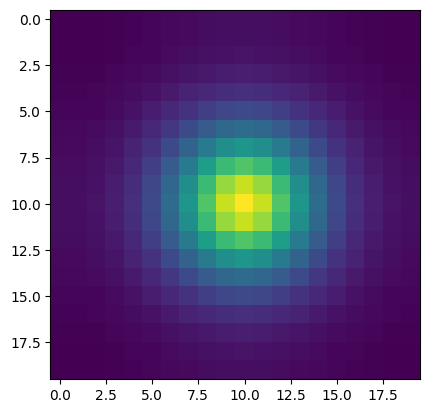

In [29]:
k_xx = kernel.K(params, state, grid, grid)
k_xx = k_xx.reshape(20,20,20,20)

plt.imshow(k_xx[10,10])

Next, we will construct a product kernel 
$$
k((x,y), (x',y')) = k_X(x,x') k_X(y,y')
.
$$
We start by construcitng a kernel on the circle $Y$, and plot it.

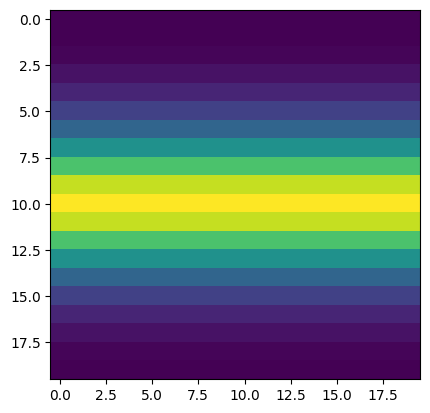

In [30]:
kernel_single = MaternKarhunenLoeveKernel(Circle(), 11)

params_single, state_single = kernel_single.init_params_and_state()
params_single['nu'] = B.repeat(2.5,1)

k_xx_single_1 = kernel_single.K(params_single, state_single, grid[..., :1], grid[..., :1]).reshape(20,20,20,20)
plt.imshow(k_xx_single_1[10,10])


Similarly, we can construct and plot the kernel on $X$, which lives on the other axis.

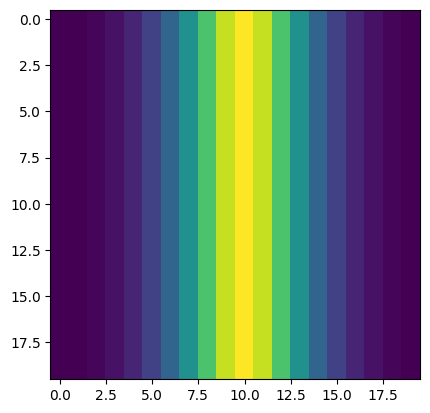

In [31]:
k_xx_single_2 = kernel_single.K(params_single, state_single, grid[..., 1:], grid[..., 1:]).reshape(20,20,20,20)
plt.imshow(k_xx_single_2[10,10])

Now, constructing the product kernel is as simple as multiplying the two kernels togetherL we plot the resulting kernel below.

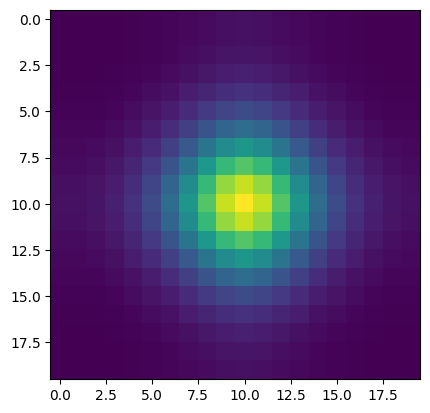

In [32]:
k_xx_product = k_xx_single_1 * k_xx_single_2
plt.imshow(k_xx_product[10,10])

The product Matérn kernel $k^{(\nu)}_{X\times Y}$ is not necessarily the same as the product of two Matérn kernels $k^{(\nu)}_X$ and $k^{(\nu)}_Y$ on its components: in general, we have
$$
k_{X\times Y}^{(\nu)}((x,y), (x',y')) \neq k^{(\nu)}_X(x,x') k^{(\nu)}_X(y,y')
.
$$
This is only true for the squared exponential kernel $\nu = \infty$. 
The difference, however, can be numerically small, as we see below: in practice, we can recommend using both variants, since in most cases they will behave similarly.
One advantage of working with $k^{(\nu)}_X(x,x') k^{(\nu)}_X(y,y')$ is that it allows one to define separate length scales for each kernel, allowing one to apply techniques such as *automatic relevance determination* on manifolds.

In [33]:
B.abs(k_xx - k_xx_product).max()

0.022036036149764272